In [1]:
import os
import sys
import warnings
warnings.simplefilter("ignore")

In [2]:
import numpy as np
import tqdm as tqdm

# visualization
import matplotlib.pyplot as plt
import math
pi = math.pi

# tf and friends
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import sonnet as snt

2024-07-21 06:45:29.966223: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 06:45:29.967336: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 06:45:29.989146: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 06:45:29.989869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 06:45:30.350116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [35]:
print("TensorFlow version {}".format(tf.__version__))
tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

TensorFlow version 2.13.1


In [4]:
# Load referene MD simulation data for statistics & Loss_DD & Plotting
traindata = np.loadtxt('./data/simulated_xy.dat').astype(np.float32) 

data_mean = np.mean(traindata,axis=0,keepdims=True)
data_std = np.std(traindata,axis=0,keepdims=True)

hop = 1
X_train = ( traindata[::hop] - data_mean ) / ( data_std+ 1e-6)

np.random.seed(1)
np.random.shuffle(X_train)

datasize, dim = X_train.shape
print(X_train.shape)

(50000, 2)


# Define Helper Functions Describing the Numerical Potential

In [5]:
np_angle = np.array([81.5/180.*math.pi])
angle = tf.constant(np_angle, dtype=tf.float32)

tf_data_mean = tf.constant(data_mean.reshape(-1,dim), dtype=tf.float32)
tf_data_std = tf.constant(data_std.reshape(-1,dim), dtype=tf.float32)

@tf.function 
def compute_s(xy): # substituion-of-variable trick
    ### xy:[bs,2]        
    x = tf.gather(xy, [0], axis=1) ### [bs,1]
    y = tf.gather(xy, [1], axis=1) ### [bs,1]
    
    s = tf.cos(angle)*x + tf.sin(angle)*y ### [bs,1]
    s = s ### [bs,1]    
    return s

beta0= 1.
@tf.function
def pes(xy): # Tiwary-Berne Potential
    xy = xy*tf_data_std + tf_data_mean
    
    x = tf.gather(xy, [0], axis=1) ### [bs,1]
    y = tf.gather(xy, [1], axis=1) ### [bs,1]
    
    u1 = -16.* tf.exp( -2.*(x+0.5)**2 - 2.*(y-0.5)**2 )
    u2 = -18.* tf.exp( -2.*(x-0.8)**2 - 2.*(y-1.2)**2 )
    u3 = -16.* tf.exp( -2.*(x-0.5)**2 - 2.*(y+0.3)**2 )
    u4 = 0.5* (x**6 + y**6)
    
    u = u1 + u2 + u3 + u4
    
    return u

2024-07-21 06:45:32.690646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 06:45:32.690833: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Define Models:

In [6]:
class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output -1 )) ### output x only
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    ### inputs = [x,s]    
    s = tf.reshape( inputs[:,-1], [-1,1])
    z = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    x_new = self._model(z)
    out = tf.concat([x_new, tf.zeros_like(s)], -1)
    return out

In [7]:
#@title Model and training parameters
LR = 1e-3  #@param
NUM_EPOCHS = 1 # 100
STACKED_FFJORDS = 3
NUM_HIDDEN = 64 
NUM_LAYERS = 3
NUM_OUTPUT = dim

BATCH_SIZE = 128  #@param

In [16]:
#@title Building bijector
tol = 1e-5
solver = tfp.math.ode.DormandPrince(atol=tol)
ode_solve_fn = solver.solve

trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact # recommended for late-stage training & inference
# trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson # recommended for early-stage training
bijectors = []

for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
        
    next_ffjord = tfb.FFJORD(
        state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
        trace_augmentation_fn=trace_augmentation_fn)
    bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

Define Functions for Factorized sampling & CCG:

In [17]:
@tf.function
def get_prior(xy):
    s = compute_s(xy)
   
    base_loc = tf.zeros([BATCH_SIZE,dim-1], tf.float32)
    base_loc = tf.concat([base_loc,s], axis=-1)
    base_sigma = tf.ones([BATCH_SIZE,dim], tf.float32)
    
    return (base_loc, base_sigma)

In [18]:
#@title Rare-Event-Free Sampling
@tf.function
def get_neg_samples(xy):
    s = compute_s(xy)
    noise = tf.random.normal(tf.shape(s))
    z = tf.concat([noise, s], -1)
    z = tf.stop_gradient(z) ### Do Not backprop through the base

    transformed_sample = stacked_ffjord.forward(z)
    neg_x = tf.reshape( transformed_sample[:,0], [-1,1])
    neg_y = (s - neg_x*tf.cos(angle))/tf.sin(angle)
    
    xy = tf.concat([neg_x,neg_y],axis=-1)
    
    return xy


In [19]:
#@title CCG
@tf.function
def vfe(xy, transformed_distribution):
    
    s = compute_s(xy)
    x = tf.reshape( xy[:,0], [-1,1])    
    target_sample = tf.concat([x, s], -1)
    
    entropy = tf.reduce_mean(transformed_distribution.log_prob(target_sample))
    enthalpy = tf.reduce_mean( beta0 * pes(xy) )
    
    return entropy, enthalpy


Checkpoint path

In [20]:
chk_root = "./checkpoints"
chk_name = "ffjord"
save_prefix = os.path.join(chk_root,chk_name)
checkpoint = tf.train.Checkpoint(model=stacked_ffjord)

Training:

In [13]:
#@title Dataset
DATASET_SIZE = datasize//BATCH_SIZE * BATCH_SIZE
print('Iter:', datasize//BATCH_SIZE)

hold_data = X_train[:DATASET_SIZE]

my_ds = tf.data.Dataset.from_tensor_slices(hold_data.astype(np.float32))
my_ds = my_ds.prefetch(tf.data.experimental.AUTOTUNE)
my_ds = my_ds.cache()
my_ds = my_ds.shuffle(DATASET_SIZE)
my_ds = my_ds.batch(BATCH_SIZE)


#@title Training
@tf.function
def train_step(optimizer, xy_pos, step):    
    s_pos = compute_s(xy_pos)
    x_pos = tf.reshape( xy_pos[:,0], [-1,1])
    
    target_sample = tf.concat([x_pos, s_pos], -1)
        
    (base_loc, base_sigma) = get_prior(xy_pos) ### 
    base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
        
    transformed_distribution = tfd.TransformedDistribution(
        distribution=base_distribution, bijector=stacked_ffjord)      
    
    with tf.GradientTape() as tape:

        nll = -tf.reduce_mean(transformed_distribution.log_prob(target_sample)) ### negative log-Likelihood
        loss_DD = nll
        
        neg_sample = get_neg_samples(xy_pos)
        entropy, enthalpy = vfe(neg_sample, transformed_distribution)
        loss_PI = entropy + enthalpy
        
        coeff_PI = step
        loss = (1.-coeff_PI)*loss_DD + coeff_PI*loss_PI       
        
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply(gradients, variables)
    return loss_DD, entropy, enthalpy, neg_sample


Iter: 390


In [14]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

In [25]:
latest = tf.train.latest_checkpoint(chk_root)
if latest is not None:
    checkpoint.restore(latest)
    
for epoch in tqdm.trange(NUM_EPOCHS):
    count = 0
    for batch in my_ds:
        count += 1
        step = tf.clip_by_value(count/100., 0.5, 1.)
        _loss1, _entropy, _enthalpy, _neg_sample = train_step(optimizer, batch, step)
        
        if count%10 == 0:
            print(count, np.array(_loss1), -np.array(_entropy), np.array(_enthalpy) )
        
    checkpoint.save(save_prefix)

  0%|          | 0/1 [00:00<?, ?it/s]

10 1.0305569 1.0475106 -16.030758
20 0.68329704 1.2084259 -16.098473
30 1.2863568 1.1115756 -16.214605
40 0.91405094 1.1776597 -16.125408
50 1.4066013 1.0811511 -16.196316
60 1.1618075 0.8967259 -16.093159
70 0.61295986 1.0987356 -16.079216
80 0.6501496 1.4132545 -16.026743
90 0.927644 1.2123892 -16.010292
100 1.1146021 1.5192711 -16.062992
110 0.9965166 1.0204259 -16.023087
120 1.1207803 0.62807035 -16.004467
130 1.2390711 1.5386702 -15.9329815
140 0.96769106 1.27695 -16.064316
150 0.94709694 1.0739508 -16.093803
160 1.173251 1.2450175 -16.141714
170 0.92108 1.443959 -16.064617
180 1.3808656 1.3761044 -15.9973345
190 1.1030518 1.5471218 -15.958094
200 1.1590714 1.0282333 -16.140406
210 1.5435976 1.502605 -15.893402
220 0.8902821 1.3695912 -15.953716
230 0.8460045 1.053392 -15.848297
240 1.0682406 1.3294282 -15.921957
250 1.1573462 1.13179 -16.058292
260 1.3365535 1.1336892 -15.870579
270 0.9048133 1.6946647 -16.051304
280 0.9973481 1.3729917 -16.062365
290 1.1717873 0.8325561 -16.0743

100%|██████████| 1/1 [00:34<00:00, 34.23s/it]

390 0.80958855 0.9690267 -16.094398


Inference:

In [26]:
latest = tf.train.latest_checkpoint(chk_root)
if latest is not None:
    checkpoint.restore(latest)

### Compute Coarse-Grained Potential (PMF):

In [27]:
#@title Samples
@tf.function
def vpmf(xy_in, noise_in):
    ### xy_in: np array
    ### noise: [bs]
    xy = tf.convert_to_tensor(xy_in, dtype=tf.float32)
    
    s = compute_s(xy)
    
    noise = tf.convert_to_tensor( noise_in, dtype=tf.float32)
    
    z = tf.concat([noise, s], -1) ### [bs,2]
    z = tf.stop_gradient(z) ### Do Not backprop through the base
    
    ###
    (base_loc, base_sigma) = get_prior(xy) ### 
    base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
    
    transformed_distribution = tfd.TransformedDistribution(
        distribution=base_distribution, bijector=stacked_ffjord)

    transformed_sample = stacked_ffjord.forward(z)
    neg_x = tf.reshape( transformed_sample[:,0], [-1,1])
    neg_y = (s - neg_x*tf.cos(angle))/tf.sin(angle)
    
    xy = tf.concat([neg_x,neg_y],axis=-1)
    ####
    
    x = tf.reshape( xy[:,0], [-1,1])    
    target_sample = tf.concat([x, s], -1)
    
    entropy = tf.reduce_mean(transformed_distribution.log_prob(target_sample))    
    enthalpy = tf.reduce_mean( beta0 * pes(xy) )
    
    fe = entropy + enthalpy
    
    return fe

In [28]:
np.random.seed(1)
noise_in = np.random.normal(size=BATCH_SIZE).reshape(BATCH_SIZE,1)

def calc_pmf(s_in, noise_in=noise_in):
    x_in = s_in*np.cos(np_angle)
    y_in = s_in*np.sin(np_angle)

    xy_in = np.array([x_in,y_in]).reshape(1,2)
    xy_in = (xy_in - data_mean)/(data_std + 1e-6)

    xy_in = xy_in.astype(np.float32)
    xy_in = tf.tile(xy_in,[BATCH_SIZE,1])
    noise_in = noise_in.astype(np.float32)

    pmf = vpmf(xy_in,noise_in)
    
    return np.array(pmf)

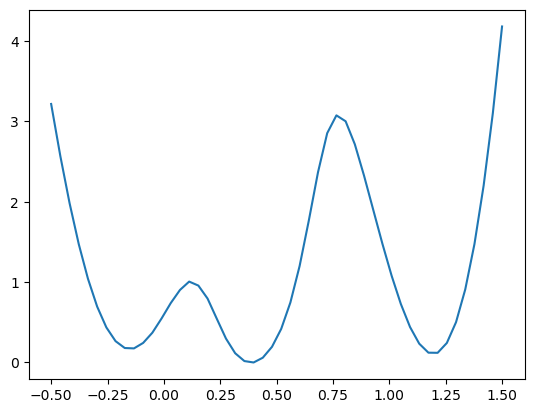

In [29]:
s_lin = np.linspace(-0.5,1.5,50)

pmf_list  = []
for s in s_lin:
    pmf = calc_pmf(s)
    pmf_list.append(np.array(pmf))

pmf = np.array(pmf_list)
pmf -= np.amin(pmf) # unit: kT
plt.plot(s_lin, pmf)
plt.show()

### Factorized Sampling:

In [30]:
### Factorized Sampling:
iters = 10

xy_list = []
for _ in range(iters):
    np.random.shuffle(X_train)
    xy_pos = X_train[:BATCH_SIZE]        
    neg_sample = get_neg_samples(xy_pos)
    neg_sample = neg_sample*data_std + data_mean
    
    xy_pos = xy_pos*data_std + data_mean
    s_pos = compute_s(xy_pos)
    
    xy_list.append(np.concatenate([np.array(neg_sample),np.array(s_pos)],axis=1))

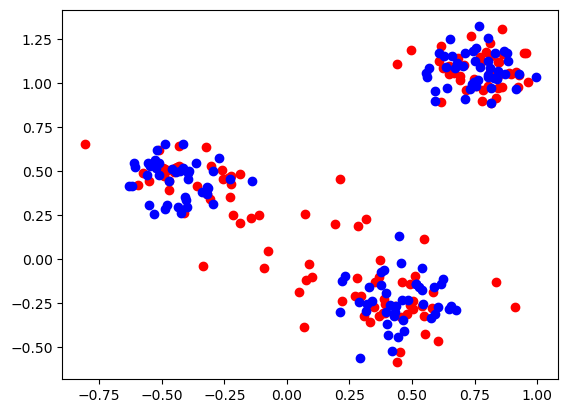

In [31]:
plt.scatter(neg_sample[:,0],neg_sample[:,1], c='r')
plt.scatter(xy_pos[:,0],xy_pos[:,1], c='b')
plt.show()

### Intrapolate traj:

In [32]:
### Intrapolate traj:

#@title Samples
@tf.function
def interpolate(xy_in, noise_in):
    ### xy_in: np array
    ### noise: [bs]
    xy = tf.convert_to_tensor(xy_in, dtype=tf.float32)
    
    s = compute_s(xy)
    print(tf.shape(s))
    
    noise = tf.convert_to_tensor( noise_in, dtype=tf.float32)
    
    z = tf.concat([noise, s], -1) ### [bs,2]
    z = tf.stop_gradient(z) ### Do Not backprop through the base
    
    ###
    (base_loc, base_sigma) = get_prior(xy) ### 
    base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)
    
    transformed_distribution = tfd.TransformedDistribution(
        distribution=base_distribution, bijector=stacked_ffjord)

    ###transformed_sample = stacked_ffjord.inverse(z)
    transformed_sample = stacked_ffjord.forward(z)
    neg_x = tf.reshape( transformed_sample[:,0], [-1,1])
    neg_y = (s - neg_x*tf.cos(angle))/tf.sin(angle)
    
    xy = tf.concat([neg_x,neg_y],axis=-1)
        
    return xy

In [33]:
np.random.seed(1)
noise_in = np.random.normal(size=BATCH_SIZE).reshape(BATCH_SIZE,1)

def interpolate_s(s_in, noise_in=noise_in):
    
    x_in = s_in*np.cos(np_angle)
    y_in = s_in*np.sin(np_angle)

    xy_in = np.array([x_in,y_in]).reshape(1,2) ### [1,2]
    xy_in = (xy_in - data_mean)/(data_std + 1e-6)

    xy_in = xy_in.astype(np.float32)
    xy_in = tf.tile(xy_in,[BATCH_SIZE,1])
    noise_in = noise_in.astype(np.float32)

    xy_traj = interpolate(xy_in,noise_in)
    
    return np.array(xy_traj)

Tensor("Shape:0", shape=(2,), dtype=int32)


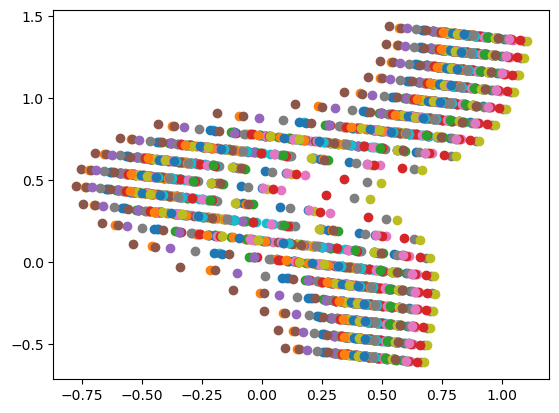

In [34]:
s_lin = np.linspace(-0.5,1.5,20)

np.random.seed(1)
noise_in = np.random.normal(size=BATCH_SIZE).reshape(BATCH_SIZE,1)

s_traj_list  = []
for s in s_lin:
    xy_traj = interpolate_s(s,noise_in)
    s_traj_list.append(np.expand_dims(np.array(xy_traj),axis=1))

s_traj = np.concatenate(s_traj_list,axis=1)
s_traj  = s_traj * data_std + data_mean
# print(s_traj.shape)

plt.figure()
for i in range(len(s_traj)):
    nxy = s_traj[i]
    plt.scatter(nxy[:,0], nxy[:,1])

plt.show()